# E0424649 Foh Cher Ern Don Assignment 2

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
yt = pd.read_csv("YouTube10k.csv")
yt.head()

,country,title,channel_title,category_id,publish_time,publish_time(Excel),views,likes/views,dislikes/views,comment_count/views,comments_disabled,ratings_disabled,video_error_or_removed
0,KR,Zlatan is Back! God! Ibrahimovic! LA Galaxy 4-...,NIXBLACK,17,38:17.0,43190.90159,3911688,0.014061,0.000480,0.001772,False,False,False
1,KR,포항지진피해,디언사,22,26:41.0,43054.43520,126445,0.001558,0.000182,0.002230,False,False,False
2,DE,Celtic Music – Bathed in Light | Beautiful Fan...,Music for your soul - Ean Grimm,10,49:13.0,43098.53418,436172,0.003677,0.000798,0.000197,False,False,False
3,DE,CREEPY Voicemail Message Is Shaking The Internet,secureteam10,28,31:10.0,43175.56331,536117,0.035597,0.002115,0.016278,False,False,False
4,GB,Moby - Like A Motherless Child (Official Video),Moby,10,01:25.0,43080.62598,159436,0.032853,0.001273,0.001725,False,False,False


At first glance, it seems like some features will likely not be relevant at all, such as "title" and "channel_title" as these are likely to be unique for every video.
<br>
<br>
Additionally, some features appear to be categorical, such as "country" and "category_id". These will have to be converted to dummy variables with baseline dropped to prevent multicollinearity.
<br>
<br>
Moreover, some features, such as "comments_disabled", are boolean and should be converted to indicator variables.
<br>
<br>
Finally, "publish_time" and "publish_time(Excel)" seem to be referring to the same thing, and hence one should be dropped. As I do not quite recognize the format for "publish_time", while I know "publish_time(Excel)" is in Excel date time format, I believe "publish_time(Excel)" should be kept and it should also be converted to datetime format.

# Data preprocessing - Incl. dealing with categorical variables

In [3]:
yt.isna().sum()

country                   0
title                     0
channel_title             0
category_id               0
publish_time              0
publish_time(Excel)       0
views                     0
likes/views               0
dislikes/views            0
comment_count/views       0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
dtype: int64

There are no missing values.

In [4]:
# Drop irrelevant columns
yt_clean = yt.drop(columns=["title", "channel_title", "publish_time"])

# Convert publish_time(Excel) to datetime format
yt_clean["publish_time_datetime"] = yt["publish_time(Excel)"].apply(lambda x: datetime.datetime(1899, 12, 30) + datetime.timedelta(days= x))
yt_clean["publish_year"] = yt_clean["publish_time_datetime"].apply(lambda x: x.year)
yt_clean["publish_month"] = yt_clean["publish_time_datetime"].apply(lambda x: x.month)
yt_clean = yt_clean.drop(columns=["publish_time_datetime", "publish_time(Excel)"])

# Convert boolean to indicator
boolean_variables = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
yt_clean[boolean_variables] = yt_clean.loc[:, boolean_variables].astype(int)

# Convert categorical variables to dummy
categorical_variables = ["category_id", "country", "publish_month", "publish_year"]
yt_clean = yt_clean.join(pd.get_dummies(yt_clean[categorical_variables].astype(str), drop_first=True)).drop(columns=categorical_variables)

In [5]:
yt_clean.head()

,views,likes/views,dislikes/views,comment_count/views,comments_disabled,ratings_disabled,video_error_or_removed,category_id_10,category_id_15,category_id_17,...,publish_year_2008,publish_year_2009,publish_year_2010,publish_year_2011,publish_year_2012,publish_year_2013,publish_year_2015,publish_year_2016,publish_year_2017,publish_year_2018
0,3911688,0.014061,0.000480,0.001772,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,126445,0.001558,0.000182,0.002230,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,436172,0.003677,0.000798,0.000197,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,536117,0.035597,0.002115,0.016278,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,159436,0.032853,0.001273,0.001725,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


# "Baseline" model, no transformations or interactions
Firstly, I will fit a model on all features without doing any further data processing, such as transformations or interactions. This will serve as a "baseline" model.

In [6]:
# Train test split
X = yt_clean.drop(columns=["likes/views"])
y = yt_clean["likes/views"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Helper function to train model given X and y, returns sm model
def get_model(X, y):
    ols = sm.OLS(y, sm.add_constant(X)).fit()
    
    return ols

In [8]:
ols = get_model(X_train, y_train)

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            likes/views   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     77.20
Date:                Sat, 05 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:35:37   Log-Likelihood:                 14504.
No. Observations:                7000   AIC:                        -2.890e+04
Df Residuals:                    6948   BIC:                        -2.855e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Diagnostics

In [9]:
# Helper function to plot diagnostic plots, given sm model
def get_diagnostic_plots(model):
    
    residuals = model.resid
    y_pred = model.fittedvalues 
    
    fig, axs = plt.subplots(3, figsize=(15, 15))
    sns.regplot(x=y_pred, y=residuals, ci=False, line_kws={"color": "red"}, ax=axs[0])
    axs[0].title.set_text("Residual vs Fits")

    sm.qqplot(residuals, line="45", fit=True, ax=axs[1])
    axs[1].title.set_text("Normal Q-Q")

    sm.graphics.plot_leverage_resid2(model, ax=axs[2])
    plt.show()

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


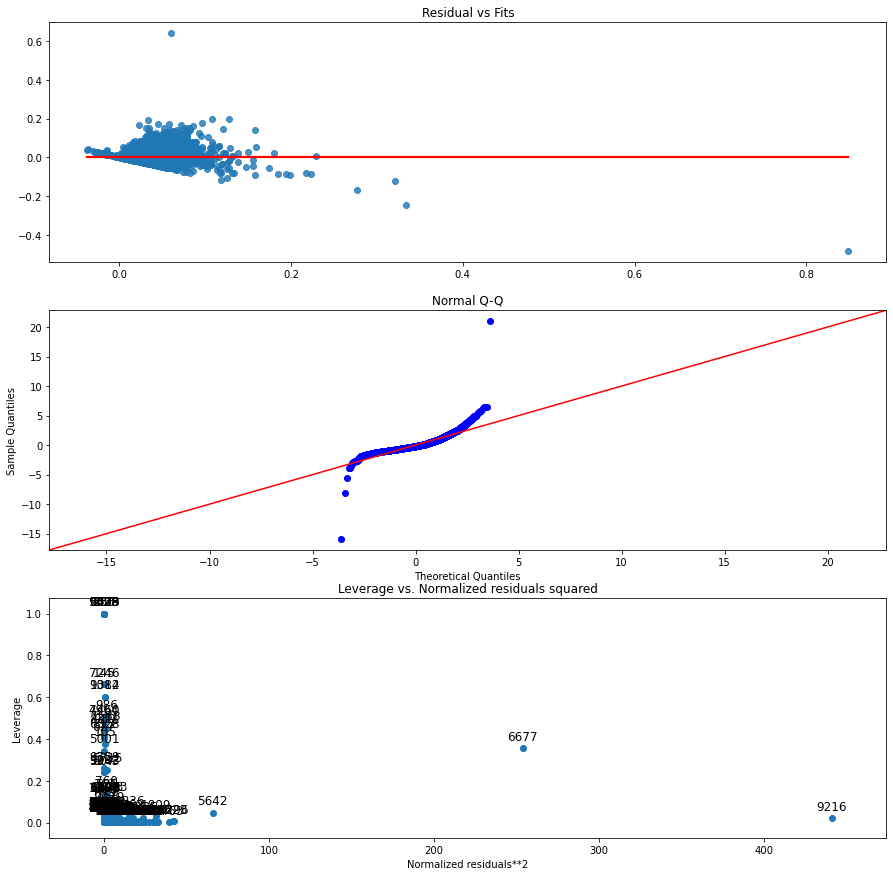

In [10]:
get_diagnostic_plots(ols)

From the residuals vs fitted plot, we can observe a "wedge" shape, with the residuals being more spread out as the the fitted value increases. This implies that there is heteroskedasticity which should be dealt with.
<br>
<br>
Moreover, the residuals vs fitted plot has a few points which are extremely far away from the rest of the points, such as the one on the bottom right, suggesting that there may be some outliers.
<br>
<br>
From the Normal Q-Q plot, we can also observe that the distribution of residuals is not normal. According to https://stats.stackexchange.com/questions/481413/how-to-interpret-this-shape-of-qq-plot-of-standardized-residuals, the shape of the Q-Q plot indicates that the residuals at the left and right tails of the distribution are much further away from the mean than expected if the distrubtion of residuals was normal. This suggests that extreme values of residuals is more likely than expected.
<br>
<br>
There are some points with both high leverage and a large residual, such as 6677. This suggests that there are some outliers affecting the accuracy of our linear regression. 


### Discussion
Adjusted r2 of the "baseline" model is 0.357. 
<br>
<br>
According to the diagnostic plots, it seems like 2 issues with the base model are the presence of outliers along with heteroskedasticity. Hence, to improve model performance, I will attempt to deal with these 2 issues by detecting and removing outliers and transforming variables. 

# Outlier detection
I will attempt to remove outliers firstly through automatic methods which were covered in class, following which I will do a manual check to see if any outliers remain and remove them accordingly.

### Automatic outlier detection
Outliers will be detected with IsolationForest and LocalOutlierFactor <br>
One model will be fit for each set of identified outliers excluded <br>
The model which produces the best adjusted r2 will be selected.

In [11]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [12]:
train = X_train.join(y_train)

# Isolation forest
iso = IsolationForest(random_state=42)
iso_pred = iso.fit_predict(train)

# LocalOutlierFactor
lof = LocalOutlierFactor()
lof_pred = lof.fit_predict(train)

models = {}
for outlier_algo, pred in {"IsolationForest": iso_pred, "LocalOutlierFactor": lof_pred}.items():
    X_train_inlier = X_train[pred == 1]
    y_train_inlier = y_train[pred == 1]

    inlier_ols = get_model(X_train_inlier, y_train_inlier)
    
    models[outlier_algo] = inlier_ols
    print(outlier_algo, ": ", inlier_ols.rsquared_adj)

IsolationForest :  0.3913787124982072
LocalOutlierFactor :  0.3581412318172479


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


IsolationForest identified the best set of outliers, with a 0.034 increase in adjusted r2 from baseline.

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


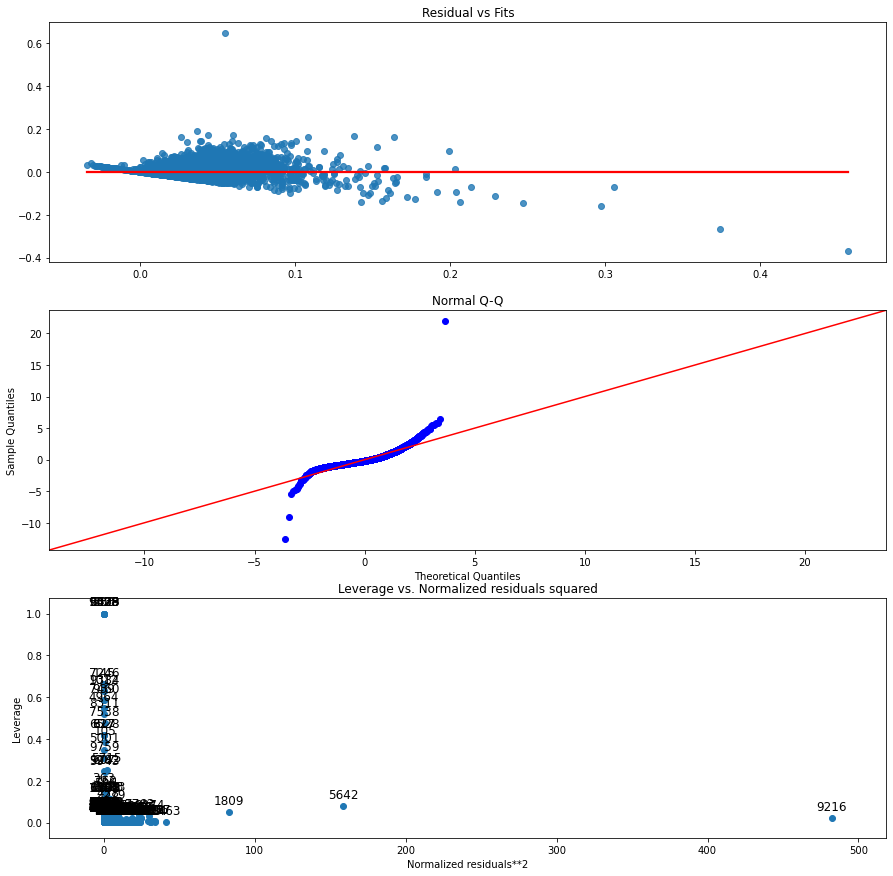

In [13]:
get_diagnostic_plots(models["IsolationForest"])

The point with high leverage and a large residual (6677) has been removed.
<br>
<br>
However, according to the residual vs fits plot, there still seems to be some outliers, such as the two points in the bottom right corner and the point in the top left corner. I will identify and remove these points manually.

### Manual outlier detection
From the residual vs fits plot, I noted that the outliers occured where residuals < -0.2 and also where residuals > 0.6.

In [14]:
more_outliers = np.concatenate((np.where(models["IsolationForest"].resid > 0.6)[0], np.where(models["IsolationForest"].resid < -0.2)[0]))

X_train_no_outliers = X_train[iso_pred == 1]
X_train_no_outliers = X_train_no_outliers.drop(X_train_no_outliers.index[more_outliers], axis=0)

y_train_no_outliers = y_train[iso_pred == 1]
y_train_no_outliers = y_train_no_outliers.drop(y_train_no_outliers.index[more_outliers])

In [15]:
ols_no_outliers = get_model(X_train_no_outliers, y_train_no_outliers)

print(ols_no_outliers.summary())


                            OLS Regression Results                            
Dep. Variable:            likes/views   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     105.0
Date:                Sat, 05 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:35:47   Log-Likelihood:                 14997.
No. Observations:                6923   AIC:                        -2.989e+04
Df Residuals:                    6871   BIC:                        -2.953e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


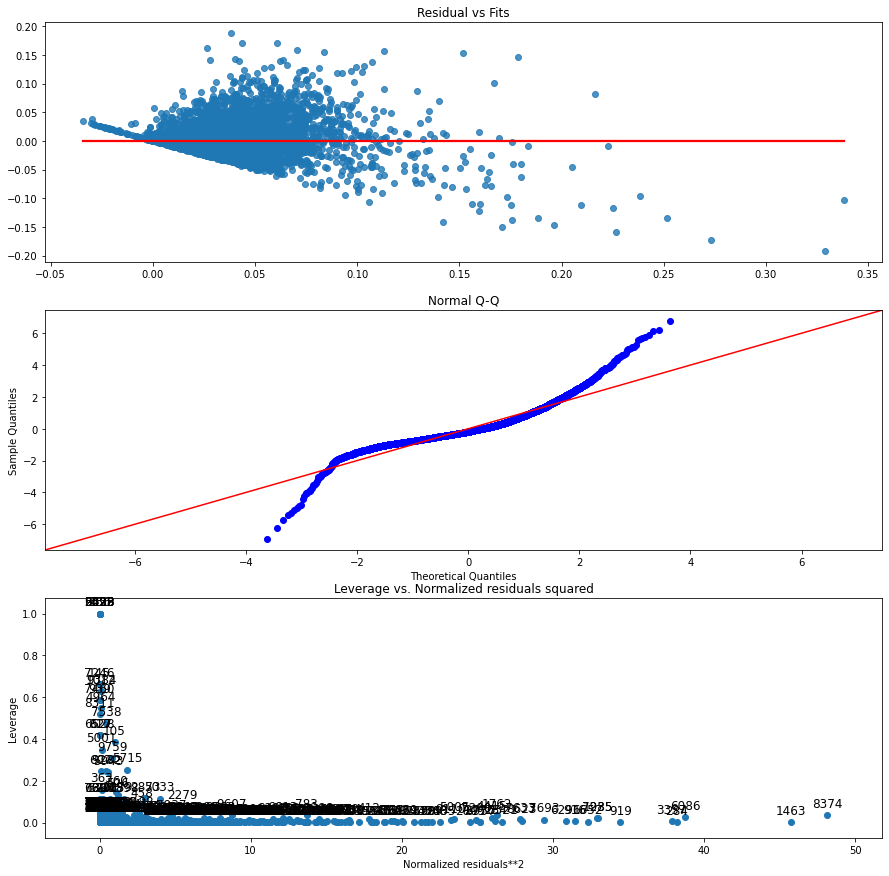

In [16]:
get_diagnostic_plots(ols_no_outliers)

### Discussion
Further removal of the outliers improved adjusted r2 even more to 0.434. 
<br>
<br>
The points in the residual vs fits plot looks to be closer together, and the normal Q-Q plot also appears to be closer to the 45 degree line, indicating that the residuals more closely follow a normal distribution after outliers have been removed.
<br>
<br>
However, from the residuals vs fits plot, hetereoskedasticity is still present, as evidenced by the wedge shape which shows increasing variance of residuals as likes/views increases.

# Dealing with heteroskedasticity - variable transformation
To deal with heteroskedasticity, I attempt to find possible non-linear relationships between likes/views and the features. 
<br>
<br>
This will be done by first square transforming and square-root transforming all numerical features, and then adding those as additional features to the model.
<br>
<br>
Transformed features (along with their original non-transformed counterparts) will then have their p-values checked, and the feature with the highest p-value will be discarded. This process will repeat iteratively until all the transformed (and non-transformed numerical features) have been dropped. 
<br>
<br>
The combination of features which produces the model with the highest adjusted r2 will be selected.

In [17]:
X_train_trans = X_train_no_outliers.copy()

# Square and sqrt of all numerical features
numerical_variables = ["views", "dislikes/views", "comment_count/views"]

for variable in numerical_variables:
    X_train_trans[variable + "_sq"] = X_train_trans[variable] ** 2
    X_train_trans[variable + "_sqrt"] = X_train_trans[variable] ** 0.5

In [18]:
ols_trans = get_model(X_train_trans, y_train_no_outliers)

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [19]:
removable_variables = numerical_variables.copy()
removable_variables += [variable + "_sq" for variable in numerical_variables]
removable_variables += [variable + "_sqrt" for variable in numerical_variables]

In [20]:
variables_dropped = []
trans_models = {}
trans_X_trains = {}
for variable in removable_variables:
    variables_left = [variable for variable in removable_variables if variable not in variables_dropped]
    variable_to_drop = ols_trans.pvalues[variables_left].sort_values(ascending=False).index[0]
    variables_dropped.append(variable_to_drop)
    variables_left_after_drop = [variable for variable in variables_left if variable != variable_to_drop]
    
    X_train_ = X_train_trans.drop(columns=variables_dropped)
    ols_trans = get_model(X_train_, y_train_no_outliers)
    trans_X_trains[" ".join(list(variables_left_after_drop))] = X_train_.copy()
    trans_models[" ".join(list(variables_left_after_drop))] = ols_trans
    
    print("Variables dropped: ", variables_dropped)
    print("Variables left: ", list(variables_left_after_drop))
    print("Adjusted R2 after dropping: ", ols_trans.rsquared_adj)
    print()

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWa

Variables dropped:  ['views_sq']
Variables left:  ['views', 'dislikes/views', 'comment_count/views', 'dislikes/views_sq', 'comment_count/views_sq', 'views_sqrt', 'dislikes/views_sqrt', 'comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5227726023006333

Variables dropped:  ['views_sq', 'comment_count/views_sq']
Variables left:  ['views', 'dislikes/views', 'comment_count/views', 'dislikes/views_sq', 'views_sqrt', 'dislikes/views_sqrt', 'comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5228418974200874

Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views']
Variables left:  ['views', 'comment_count/views', 'dislikes/views_sq', 'views_sqrt', 'dislikes/views_sqrt', 'comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5229093892417799

Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt']
Variables left:  ['views', 'comment_count/views', 'dislikes/views_sq', 'dislikes/views_sqrt', 'comment_count/views_sqrt']
A

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt', 'views', 'dislikes/views_sq']
Variables left:  ['comment_count/views', 'dislikes/views_sqrt', 'comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5216950748755064

Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt', 'views', 'dislikes/views_sq', 'dislikes/views_sqrt']
Variables left:  ['comment_count/views', 'comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5180141265799787

Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt', 'views', 'dislikes/views_sq', 'dislikes/views_sqrt', 'comment_count/views']
Variables left:  ['comment_count/views_sqrt']
Adjusted R2 after dropping:  0.5125338381281056

Variables dropped:  ['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt', 'views', 'dislikes/views_sq', 'dislikes/views_sqrt', 'comment_count/views', 'comment_count/views_sqrt']
Variables left:  []

From the above, it seems that the model which kept ['views', 'comment_count/views', 'dislikes/views_sq', 'dislikes/views_sqrt', 'comment_count/views_sqrt'] had the highest adjusted r2.

In [21]:
best_variables_kept = " ".join(['views', 'comment_count/views', 'dislikes/views_sq', 'dislikes/views_sqrt', 'comment_count/views_sqrt'])
print(trans_models[best_variables_kept].summary())

                            OLS Regression Results                            
Dep. Variable:            likes/views   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     144.2
Date:                Sat, 05 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:35:52   Log-Likelihood:                 15592.
No. Observations:                6923   AIC:                        -3.108e+04
Df Residuals:                    6869   BIC:                        -3.071e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


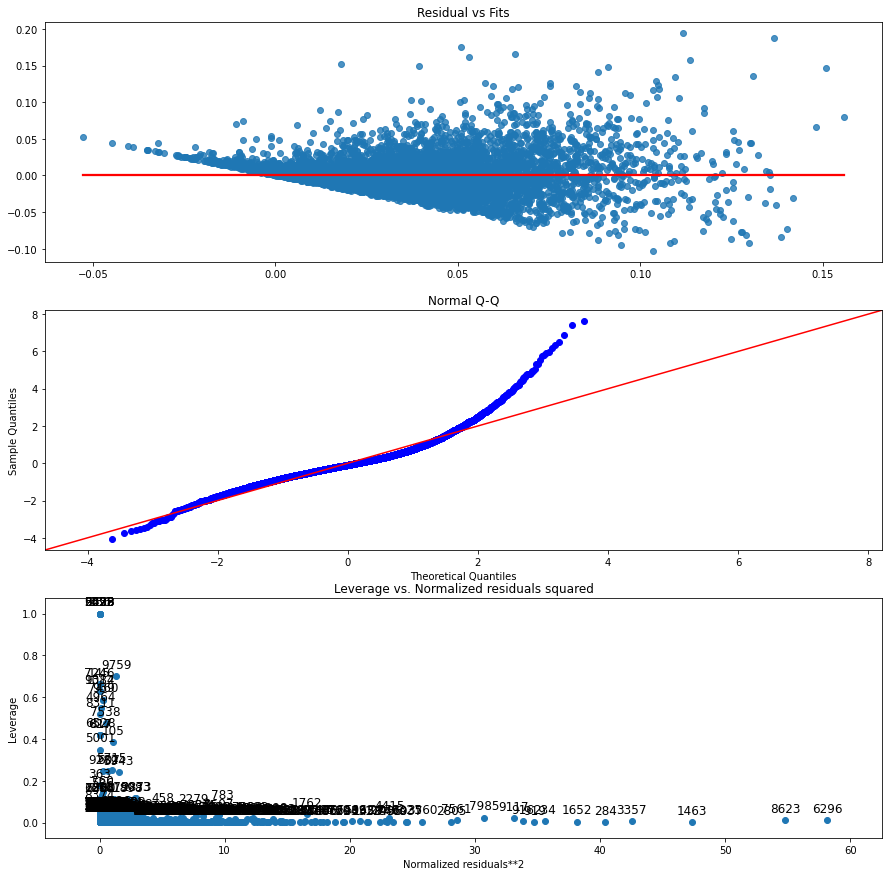

In [22]:
get_diagnostic_plots(trans_models[best_variables_kept])

From the Normal Q-Q plot, the left tail of qq plot looks to be closer to a normal distribution.
<br>
<br>
However, from the residuals vs fits plot, the wedge shape still looks to be present, indicating that there is still hetereoskedasticity. Hence, I will now try transforming dependant variable, "likes/views", in an attempt to deal with the hetereoskedasticity. 


### Transforming the dependent variable
Both a square and square root transformation will be applied to "likes/views". The model with the higher adjusted-r2 will be selected.
<br>
<br>
A log transformation as not considered as "likes/views" contains 0 values, which would have produced a NA value upon logging.

### Square root

In [23]:
X_train_trans = trans_X_trains[best_variables_kept]

y_train_trans_sqrt = y_train_no_outliers ** 0.5
y_train_trans_sqrt.name = "likes/views_sqrt"
ols_trans2 = get_model(X_train_trans, y_train_trans_sqrt)

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [24]:
print("Square root transformation adjusted r2: ", ols_trans2.rsquared_adj)

Square root transformation adjusted r2:  0.5920875375386006


### Square

In [25]:
y_train_trans_sq = y_train_no_outliers ** 2
y_train_trans_sq.name = "likes/view_sq"
ols_trans3 = get_model(X_train_trans, y_train_trans_sq)

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [26]:
print("Square transformation adjusted r2: ", ols_trans3.rsquared_adj)

Square transformation adjusted r2:  0.3577890240941858


### Discussion
Since the square root transformation yielded the higher adjusted r2, it was selected.

In [27]:
print(ols_trans2.summary())

                            OLS Regression Results                            
Dep. Variable:       likes/views_sqrt   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     190.6
Date:                Sat, 05 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:35:56   Log-Likelihood:                 9879.6
No. Observations:                6923   AIC:                        -1.965e+04
Df Residuals:                    6869   BIC:                        -1.928e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


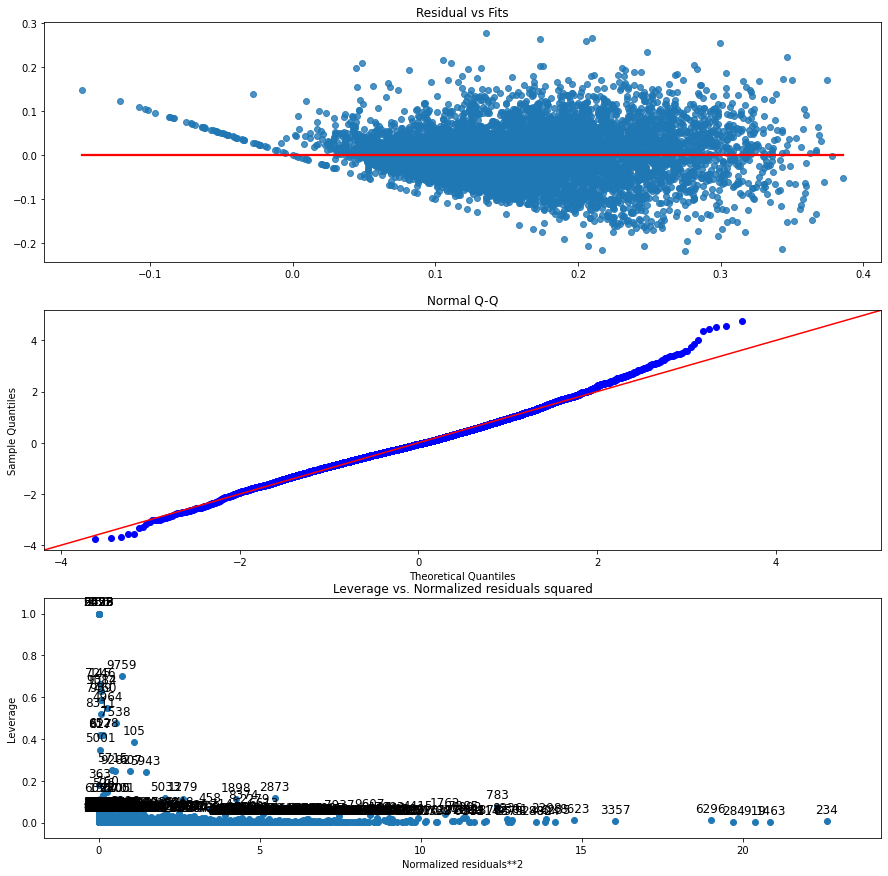

In [28]:
get_diagnostic_plots(ols_trans2)

After transforming the dependant variable, the right-tail of the Normal Q-Q plot now also appears to be closer to a normal distribution. In fact, as a whole, the residuals now appear to be normally distributed.
<br>
<br>
However, while the residuals vs fits plot does appear to have its points be slight more spread out than previously, the wedge shape still remains, which indicates that there is still hetereoskedasticity. 
<br>
<br>
Further investigation is required to identify the possible explanation. Perhaps the relationship between variables would be better represented by higher (or lower) order transformations? However, I opted to limit the transformations to squares and square-roots for better model interpretability.
<br>
<br>
Regardless, adjusted r2 of this final model has improved significantly from the baseline model, going from 0.357 to 0.592.

# Out of sample performance

In [29]:
X_test_final = X_test.copy()

for variable in numerical_variables:
    X_test_final[variable + "_sq"] = X_test_final[variable] ** 2
    X_test_final[variable + "_sqrt"] = X_test_final[variable] ** 0.5
    
X_test_final = X_test_final.drop(columns=['views_sq', 'comment_count/views_sq', 'dislikes/views', 'views_sqrt'])

y_test_final = y_test ** 0.5

y_pred_final = ols_trans2.predict(sm.add_constant(X_test_final))

print(r2_score(y_test_final, y_pred_final))


0.4845025427051499


C:\Users\don_f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Out of sample r2 is lower than train adjusted r2. However, this may be due to the presence of "anomalies" or "novelties" in the test set.

# Overall discussion of the final model and interpretation
All numerical features including transformed features, namely "views", "comment_count/views", "dislikes/views_sq", "dislikes/views_sqrt", and "comment_count/views_sqrt" were found to be statistically significant. This suggests that these variables are important in determining a videos square root of "likes/views". 
<br>
<br>
For "comment_count/views" and "comment_count/views_sqrt", the former had a negative beta while the latter had a positive beta. However, since the absolute t-value of the latter is larger, the overall effect of "comment_count/views" is seen to be positive. Similarly, the overall effect of "dislikes/views" is seen to be negative. This makes intuitive sense, as videos with more comments and views are likely to have more likes. Additionally, videos with more dislikes are likely to have less likes.
<br>
<br>
Of the boolean variables, only "comments_disabled" and "ratings_disabled" are important in determining square root of "likes/views". That "ratings_disabled" is statistically significant makes intuitive sense. If ratings are disabled, then likes will be 0. However, the reason why "comments_disabled" is statistically significant with a positive coefficient is unclear to me at the moment and will require further investigation.
<br>
<br>
For "category_id", category 10, 15, 20, 23, 26, 27, and 28 had a positive statistically significant difference from baseline, indicating that videos in these categories tend to receive more likes than the baseline category 1. On the other hand, category 17, 25, and 43 had a negative statistically significant difference from baseline, indicating that videos in these categories tend to receive less likes than category 1.
<br>
<br>
For "country", all countries were statistically significantly different from the baseline country. Videos from DE, FR, GB, IN, MX, RU, and US tended to receive more likes than the baseline country CA, while videos from KR and JP tended to receive less likes than CA.
<br>
<br>
For "month", no months were statistically significantly different from the baseline month, suggesting that month of posting a video does not play a part in how many likes a video gets.
<br>
<br>
For "year", only 2012 had a statistically significant difference in square root of likes/views from the baseline year 2007, with videos from 2012 tending to receive more likes. More investigation is required to determine why.